# PDM analysis of asteroids

The purpose of this notebook is to demonstrate the process of using phasedm for period analysis of lightcurves. In this notebook we investigate the asteroids 10 Hygeia and 2867 Steins. This data is sourced from ALCDEF https://alcdef.org/ if you're interested in trying PDM out on some more asteroids.


In [2]:
import numpy as np
import pandas as pd
from astropy.time import Time
from phasedm import pdm, beta_test
import matplotlib.pyplot as plt

In [3]:
def parse_asteroid_lightcurve(file_path):
    times = []
    magnitudes = []
    errors = []
    phases = []

    with open(file_path, "r") as file:
        lines = file.readlines()

    read_data = False
    for line in lines:
        line = line.strip()

        if line.startswith("PHASE="):
            section_phase=line.replace("PHASE=+", "")
        # Check if this is a data line
        if read_data and line.startswith("DATA="):
            # Split by the | delimiter
            parts = line.replace("DATA=", "").split("|")

            # Extract values, ensuring there are 3 parts
            if len(parts) == 3:
                time_val = float(parts[0])
                magnitude_val = float(parts[1])
                error_val = float(parts[2])

                times.append(time_val)
                magnitudes.append(magnitude_val)
                errors.append(error_val)
            
            # Add phase to validate the values we compute are correct
            phases.append(float(section_phase))

        # Check for data block markers
        if line == "ENDMETADATA":
            read_data = True
        elif line == "ENDDATA":
            read_data = False

    # Convert lists to numpy arrays
    magnitude_array = np.array(magnitudes)
    error_array = np.array(errors)
    time_array = np.array(times)
    phase_array = np.array(phases)

    # Convert JD to datetime64 (might add JD compatability in the future)
    astropy_time = Time(time_array, format="jd")
    iso_times = astropy_time.iso
    datetime_array = np.array(pd.to_datetime(iso_times))

    return datetime_array, magnitude_array, error_array, phase_array

In [4]:
def plot_lightcurve(t,y,errors,filename=None):
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        t,
        y,
        yerr=errors,
        fmt="o",
        markersize=3,
        ecolor="gray",
        elinewidth=1,
        capsize=2,
    )
    plt.xlabel("Time")
    plt.ylabel("Magnitude")
    plt.title("Asteroid Lightcurve")
    plt.gca().invert_yaxis()  # Astronomical convention: brighter is lower
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(f"outputs\\{filename}.png")
        print(f"Plot saved as '{filename}.png'")

Number of data points: 12153
Time range: 2018-09-10T20:56:20.976000000 to 2019-12-06T10:58:53.270000000
Magnitude range: 9.578 to 10.173


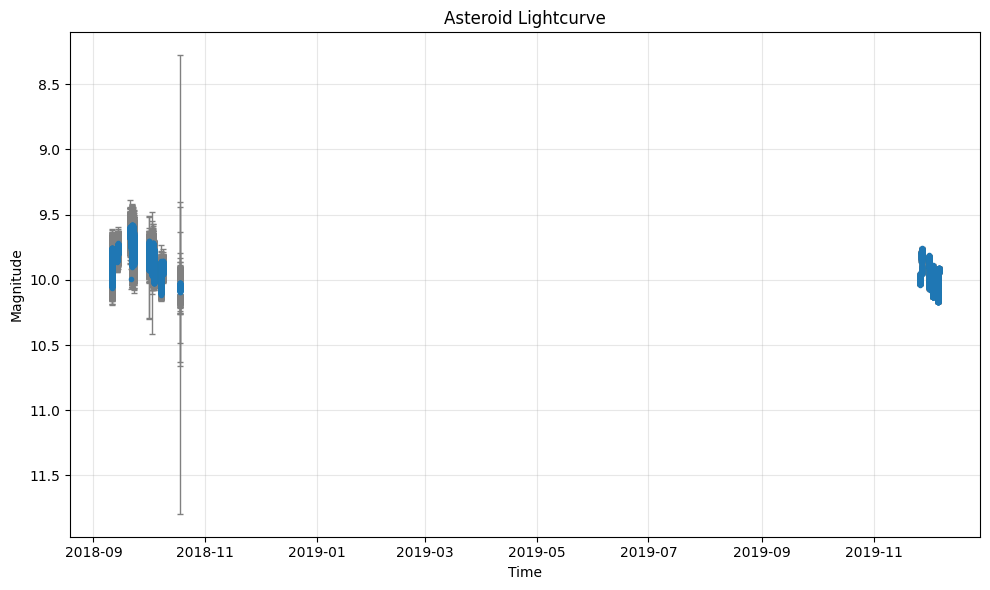

In [5]:
Hygiea_file_path = "data/ALCDEF_10_Hygiea_20250329_174535.txt"

t, y, errors, phase = parse_asteroid_lightcurve(Hygiea_file_path)

print(f"Number of data points: {len(t)}")
print(f"Time range: {min(t)} to {max(t)}")
print(f"Magnitude range: {min(y)} to {max(y)}")

plot_lightcurve(t,y,errors)


We can see there are two main periods of observation. One in late 2018 and another in late 2019. let's look at them independantly to see what happening a bit better.

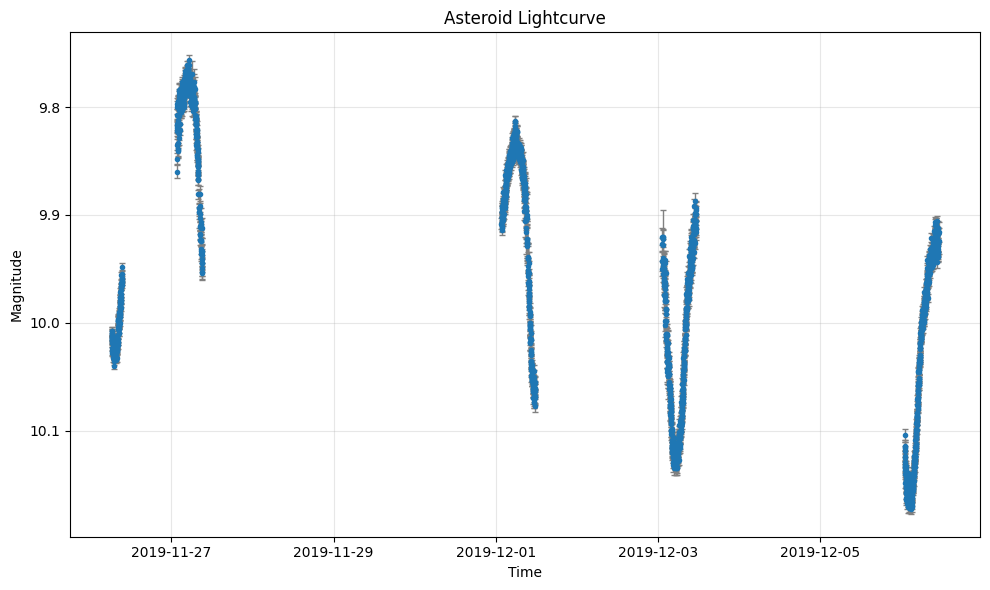

In [6]:
date = "2019-01"
slice_errors = errors[t > np.datetime64(date)]
slice_y = y[t > np.datetime64(date)]
slice_t = t[t > np.datetime64(date)]

plot_lightcurve(slice_t,slice_y,slice_errors)

In [7]:
date1 = "2018-06-15"
date2 = "2018-09-25"
mask = (t >= np.datetime64(date1)) & (t < np.datetime64(date2)) & (y > 9.95)

# Remove outlier
indices_to_remove = np.where(mask)[0]

errors = np.delete(errors, indices_to_remove)
y = np.delete(y, indices_to_remove)
t = np.delete(t, indices_to_remove)

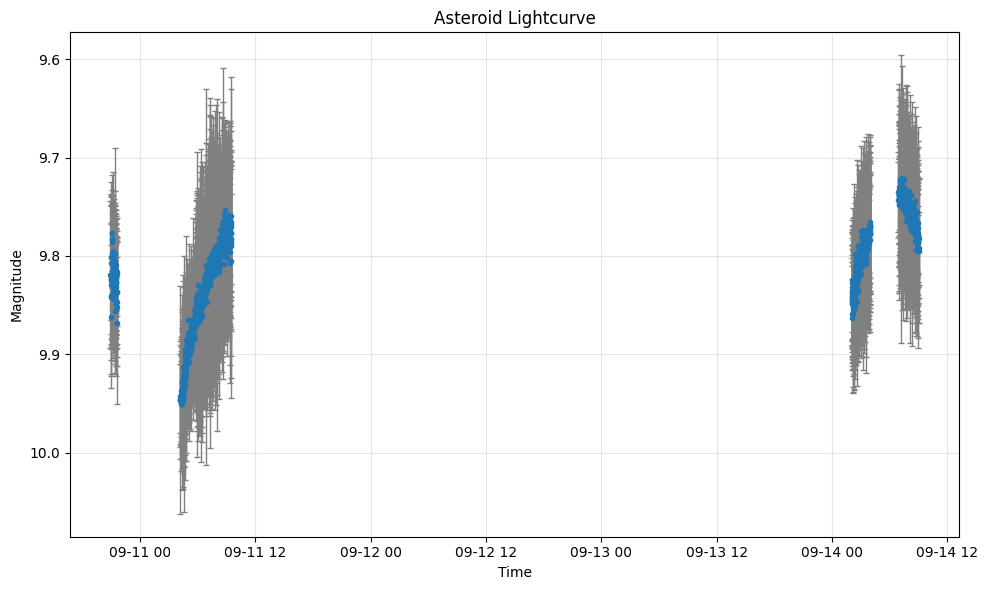

In [8]:
date1 = "2018-06-15"
date2 = "2018-09-15"

slice_errors = errors[(t >= np.datetime64(date1)) & (t < np.datetime64(date2))]
slice_y = y[(t >= np.datetime64(date1)) & (t < np.datetime64(date2))]
slice_t = t[(t >= np.datetime64(date1)) & (t < np.datetime64(date2))]

plot_lightcurve(slice_t,slice_y,slice_errors)

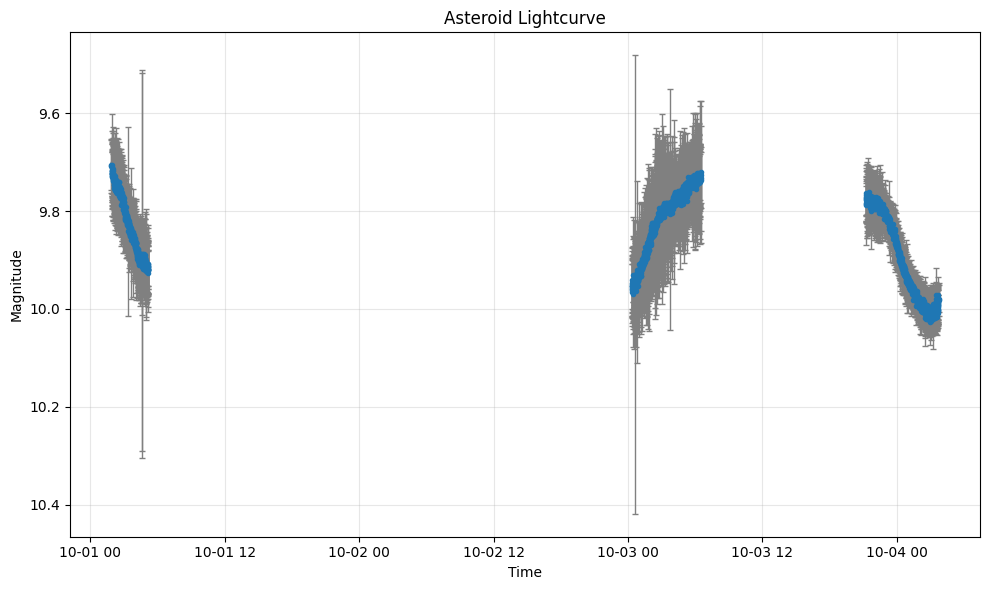

In [9]:
date1 = "2018-09-25"
date2 = "2018-10-05"


slice_errors = errors[(t >= np.datetime64(date1)) & (t < np.datetime64(date2))]
slice_y = y[(t >= np.datetime64(date1)) & (t < np.datetime64(date2))]
slice_t = t[(t >= np.datetime64(date1)) & (t < np.datetime64(date2))]

plot_lightcurve(slice_t,slice_y,slice_errors)


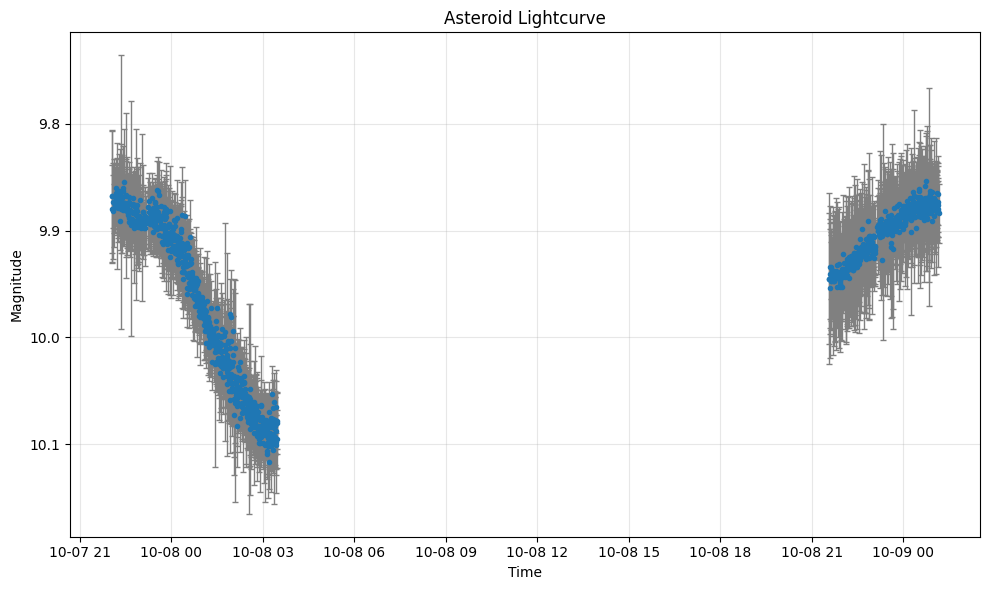

In [10]:
date1 = "2018-10-05"
date2 = "2018-10-11"

slice_errors = errors[(t >= np.datetime64(date1)) & (t < np.datetime64(date2))]
slice_y = y[(t >= np.datetime64(date1)) & (t < np.datetime64(date2))]
slice_t = t[(t >= np.datetime64(date1)) & (t < np.datetime64(date2))]

plot_lightcurve(slice_t,slice_y,slice_errors)

In [11]:
def plot_theta(freq, theta, best_freq, sig_theta):
    plt.figure()
    plt.plot(freq, theta)
    plt.axvline(best_freq, color="green", linestyle=":", label="Detected Period")

    plt.axhline(sig_theta, color="blue", linestyle="--", label="Significance Threshold")
    plt.xlabel("Frequency")
    plt.ylabel("PDM Statistic")
    plt.title("Phase Dispersion Minimisation Results")
    plt.legend()
    plt.show()

Detected period: 87495.07835262618


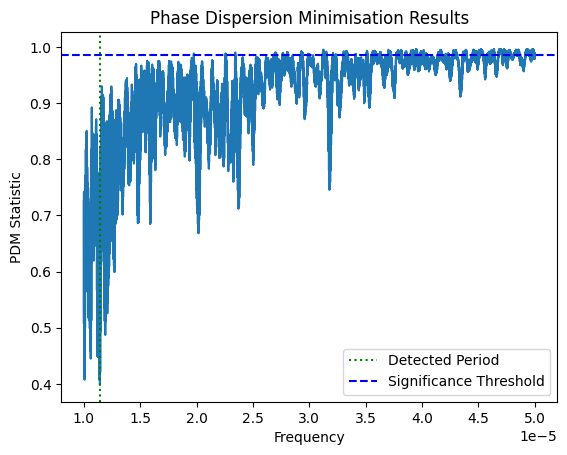

In [12]:
min_freq = 1 / 100000

max_freq = 1 / 20000
n_bins = 100
n_freqs = int(1e5)
sig_theta = beta_test(len(t), n_bins, 0.00001)

freq, theta = pdm(t, y, min_freq, max_freq, n_freqs, n_bins=n_bins, verbose=0)

sorted_indices = np.argsort(theta)
best_freq = freq[sorted_indices[0]]

print(f"Detected period: {1/best_freq}")

plot_theta(freq, theta, best_freq, sig_theta)
plt.show()

In [13]:
def plot_folded_light_curve(seconds_array, y, best_freq):
    plt.figure()
    plt.scatter(seconds_array % (1 / (1 * best_freq)), y, alpha=0.5, s=1)
    plt.xlabel("Phase")
    plt.ylabel("Magnitude")
    plt.title("Asteroid Lightcurve")
    plt.gca().invert_yaxis()  # Astronomical convention: brighter is lower
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

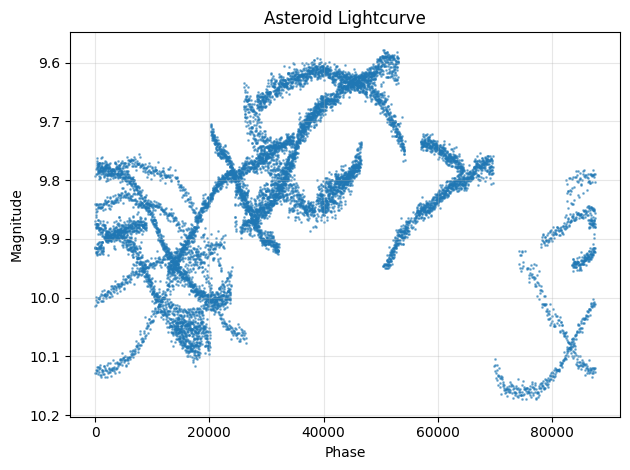

In [14]:
ns_timestamps = t.astype(np.int64)
# Convert nanoseconds to seconds (float)
seconds_array = ns_timestamps / 1e9
best_freq = freq[sorted_indices[0]]
plot_folded_light_curve(seconds_array, y, best_freq)

Hmm not very good, we should try normalising the light curves and see if that improves the results
# Normalising the light curves
We use the IAU H,G magnitude system to get a flux normalised lightcurve

In [15]:
import numpy as np
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris
from astroquery.jplhorizons import Horizons

def calculate_hygiea_distance_phase(np_datetime: np.datetime64):   
    # Convert the datetime string to an astropy Time object
    iso_time = str(np_datetime)
    time = Time(iso_time, format='isot', precision=9)
    
    try:
        solar_system_ephemeris.set('jpl')
        obj_sun = Horizons(id='Hygiea', location='@sun', epochs=time.jd)  # @sun is the Sun (heliocentric)
        sun_vectors = obj_sun.vectors()
        
        # Get position relative to Earth
        obj_earth = Horizons(id='Hygiea', location='399', epochs=time.jd)  # 399 is Earth
        earth_ephem = obj_earth.ephemerides()
        
        # Distance from Sun to Hygiea using vector magnitude
        sun_distance = np.sqrt(sun_vectors['x'][0]**2 + 
                               sun_vectors['y'][0]**2 + 
                               sun_vectors['z'][0]**2)
        
        # Distance from Earth to Hygiea (directly from ephemerides)
        earth_distance = earth_ephem['delta'][0]  # in AU
        
        # Phase angle
        phase_angle = earth_ephem['alpha'][0]  # in degrees
        
        return earth_distance, sun_distance, phase_angle
        
    except Exception as e:
        print(f"Error calculating position: {e}")
        return None, None, None
    


Extremely expensive to compute the values for every time step so we're going to cheat and use a cubic spline interpolation which should be fine as the function is very smooth (could 100% just use OLS I felt like being fancy)

In [16]:
from scipy.interpolate import CubicSpline
from tqdm import tqdm

def chebyshev_nodes(a, b, n):
    i = np.arange(n)
    theta = np.pi * (2*i + 1) / (2*n)
    return ((a + b) / 2) + ((b - a) / 2) * np.cos(theta)

def find_large_gaps(datetime_array, threshold_minutes=120):
    time_diffs = np.diff(datetime_array)
    
    diffs_minutes = time_diffs.astype('timedelta64[m]').astype(float)
    
    large_gap_indices = np.where(diffs_minutes > threshold_minutes)[0]
    
    return list(large_gap_indices)

indices = [-1]+find_large_gaps(t) +[len(t)]

# Number of chebyshev nodes
n = 3

earth_dist = []
sun_dist = []
sun_phase = []

for i in tqdm(range(len(indices)-1)):
    t_int = t.astype(np.int64)[indices[i]+1:indices[i+1]+1]
    t1 = t_int[0]
    t2 = t_int[-1]

    t_nodes = chebyshev_nodes(t1, t2, n)
    
    t_nodes = np.sort(t_nodes)
    
    # Evaluate Hygiea's phase and distance at Chebyshev nodes
    y_nodes = np.array([calculate_hygiea_distance_phase(np.datetime64(int(t),'ns')) for t in t_nodes])

    earth_dist_nodes, sun_dist_nodes, sun_phase_nodes = y_nodes[:,0], y_nodes[:,1], y_nodes[:,2] 

    # Adjust scale to fix ill conditioned matrix
    t_nodes = t_nodes/int(1e9)
    t_int = t_int/int(1e9)

    # Create cubic spline interpolation
    earth_dist_spline = CubicSpline(t_nodes, earth_dist_nodes)
    sun_dist_spline = CubicSpline(t_nodes, sun_dist_nodes)
    sun_phase_spline = CubicSpline(t_nodes, sun_phase_nodes)
    
    # Evaluate the spline for our time
    earth_dist.append(earth_dist_spline(t_int))
    sun_dist.append(sun_dist_spline(t_int))
    sun_phase.append(sun_phase_spline(t_int))

earth_dist = np.concatenate(earth_dist)
sun_dist = np.concatenate(sun_dist)
sun_phase = np.concatenate(sun_phase) 

100%|██████████| 18/18 [00:02<00:00,  6.50it/s]


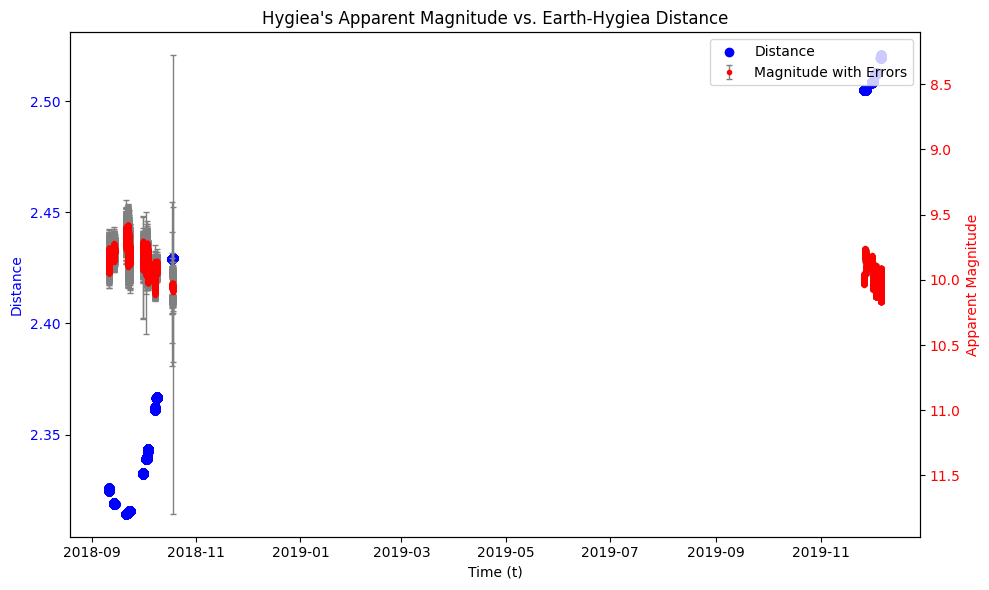

In [17]:
ig, ax1 = plt.subplots(figsize=(10, 6))

ax1.scatter(t, earth_dist, color='blue', label='Distance')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Distance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.errorbar(t, y, yerr=errors, fmt="o", markersize=3, color='red', 
             ecolor="gray", elinewidth=1, capsize=2, label='Magnitude with Errors')
ax2.set_ylabel('Apparent Magnitude', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.gca().invert_yaxis()  # Astronomical convention: brighter is lower


plt.title('''Hygiea's Apparent Magnitude vs. Earth-Hygiea Distance''')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

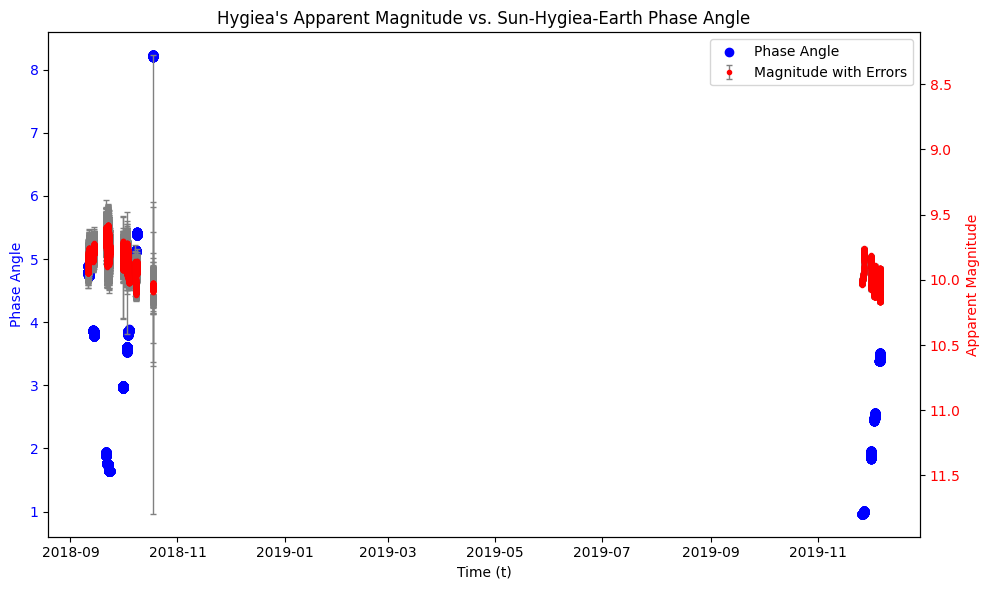

In [18]:
ig, ax1 = plt.subplots(figsize=(10, 6))

ax1.scatter(t, sun_phase, color='blue', label='Phase Angle')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Phase Angle', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.errorbar(t, y, yerr=errors, fmt="o", markersize=3, color='red', 
             ecolor="gray", elinewidth=1, capsize=2, label='Magnitude with Errors')
ax2.set_ylabel('Apparent Magnitude', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.gca().invert_yaxis()  # Astronomical convention: brighter is lower


plt.title('''Hygiea's Apparent Magnitude vs. Sun-Hygiea-Earth Phase Angle''')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

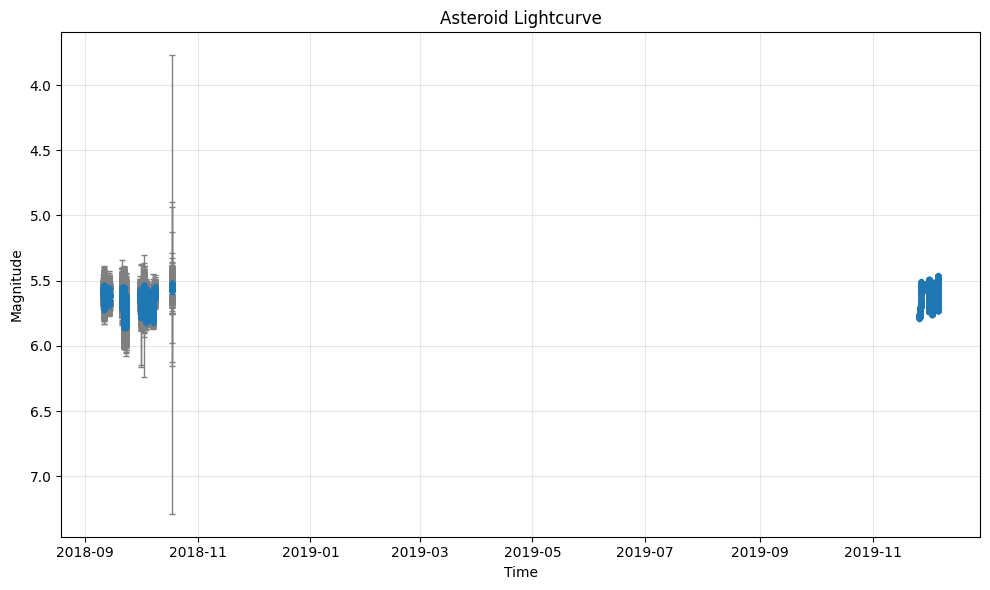

In [19]:
def normalize_light_curve(apparent_mags, r, delta, phase_angle, H=5.65, G=0.15):
    # Calculate phase function
    alpha_rad = np.radians(phase_angle)
    tan_half_alpha = np.tan(alpha_rad / 2)
    phi1 = np.exp(-3.33 * np.power(tan_half_alpha, 0.63))
    phi2 = np.exp(-1.87 * np.power(tan_half_alpha, 1.22))
    phase_term = -2.5 * np.log10((1 - G) * phi1 + G * phi2)
    
    # Calculate distance term
    distance_term = 5 * np.log10(r * delta)
    
    # Remove distance and phase effects
    absolute_mags = apparent_mags - distance_term - phase_term
    
    # Center the light curve around the H value
    mean_absolute_mag = np.mean(absolute_mags)
    normalized_mags = absolute_mags - mean_absolute_mag + H
    
    return normalized_mags
H = 5.65
G = 0.15
y_norm = normalize_light_curve(y, sun_dist, earth_dist, sun_phase, H, G)
plot_lightcurve(t,y_norm,errors)

## Phase Dispersion Minimsation

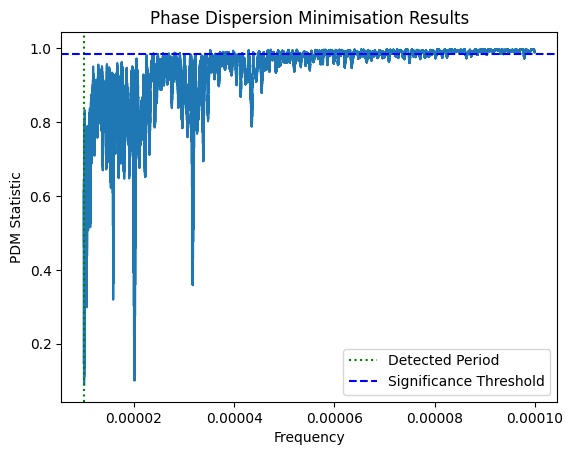

In [24]:
min_freq = 1 / 100000

max_freq = 1 / 10000
n_bins = 100
n_freqs = int(1e5)
sig_theta = beta_test(len(t), n_bins, 0.00001)

freq, theta = pdm(t, y_norm, min_freq, max_freq, n_freqs, n_bins=n_bins, verbose=0)

sorted_indices = np.argsort(theta)
best_freq = freq[sorted_indices[0]]

plot_theta(freq,theta,best_freq,sig_theta)

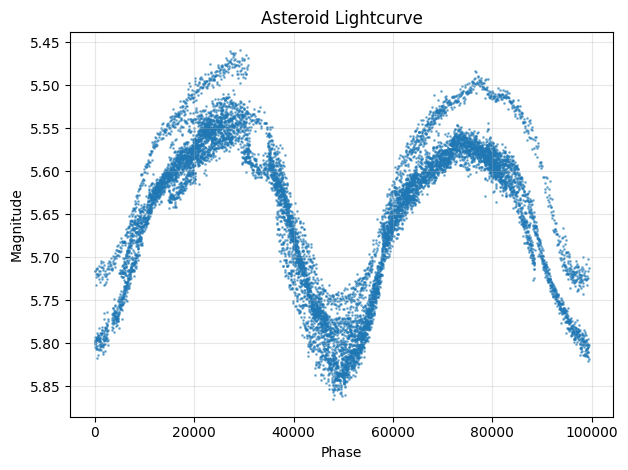

In [25]:
ns_timestamps = t.astype(np.int64)
# Convert nanoseconds to seconds (float)
seconds_array = ns_timestamps / 1e9
best_freq = freq[sorted_indices[0]]

plot_folded_light_curve(seconds_array, y_norm, best_freq)

Much better! we can see that the strongest period was a multiple of the 1st harmonic, we should restrict the search to be between about half the observed frequency.

Detected period: 49700.643504261745


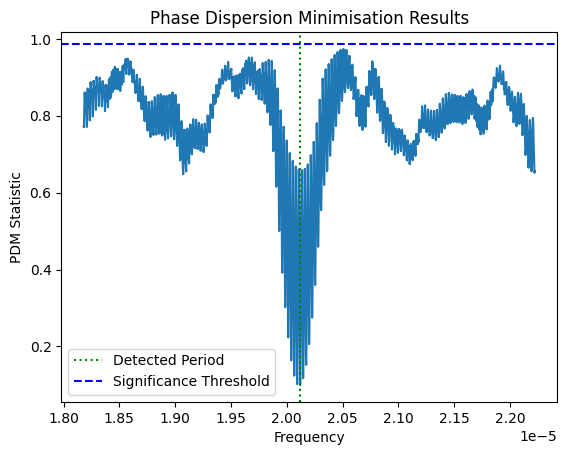

In [26]:
min_freq = 1 / 55000

max_freq = 1 / 45000
n_bins = 100
n_freqs = int(1e5)
sig_theta = beta_test(len(t), n_bins, 0.00001)

freq, theta = pdm(t, y_norm, min_freq, max_freq, n_freqs, n_bins=n_bins, verbose=0)

sorted_indices = np.argsort(theta)
best_freq = freq[sorted_indices[0]]

print(f"Detected period: {1/best_freq}")

plt.figure()
plt.plot(freq, theta)
plt.axvline(best_freq, color="green", linestyle=":", label="Detected Period")

plt.axhline(sig_theta, color="blue", linestyle="--", label="Significance Threshold")
plt.xlabel("Frequency")
plt.ylabel("PDM Statistic")
plt.title("Phase Dispersion Minimisation Results")
plt.legend()
plt.show()

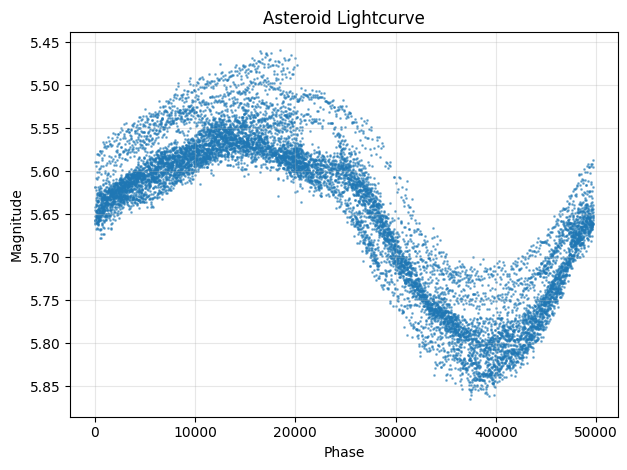

In [27]:
ns_timestamps = t.astype(np.int64)
# Convert nanoseconds to seconds (float)
seconds_array = ns_timestamps / 1e9
best_freq = freq[sorted_indices[0]]

plt.figure()
plt.scatter(seconds_array % (1 / (1 * best_freq)), y_norm, alpha=0.5, s=1)
plt.xlabel("Phase")
plt.ylabel("Magnitude")
plt.title("Asteroid Lightcurve")
plt.gca().invert_yaxis()  # Astronomical convention: brighter is lower
plt.grid(True, alpha=0.3)
plt.tight_layout()